# Face detection using Haar-like features

In this notebook you will learn to detect faces in images and videos using Haar-like features.

Requirements:

- scikit-image
- scikit-learn
- matplotlib


## Approach

The proposed approach consists of the following steps:

1. Create a dataset of face and non face patches and split it into train and test sets
2. Extract Haar-like features from the dataset
3. Train a classifier
4. Check the performance of the classifier in the test set

But first, let's import some required libraries


In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import skimage
import random

# Classifier + Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Haar-like features
from skimage.transform import integral_image, rescale, resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature


## Step 1: Create the datasets
In this notebook we are going to use a face database included in the scikit-learn library. 

Number of faces: 13233 | Size of images: (62, 47)


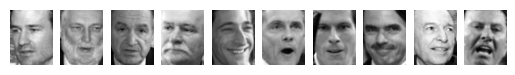

In [3]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
print(f"Number of faces: {faces.images.shape[0]} | Size of images: {faces.images.shape[1:]}")

fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(faces.images[np.random.randint(0,faces.images.shape[0])], cmap='gray')
    ax[i].axis('off')

In order to compute the Haar-like features and to speed up the computations, we are going to reduce the dataset and resize each input image to a (25,25) square.

(400, 25, 25)


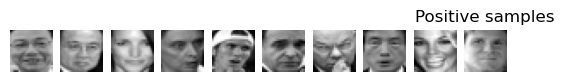

In [4]:
# Parameters
N_SAMPLES = 400
SIZE = (25, 25)

random_samples = np.random.randint(0, faces.images.shape[0], N_SAMPLES)

positive_patches = np.array([skimage.transform.resize(img, SIZE, anti_aliasing=True) for img in faces.images[random_samples]])

print(positive_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title("Positive samples")
for i in range(10):
    ax[i].imshow(positive_patches[np.random.randint(0,positive_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

Since we also need some negative examples, we are going to extract patches from sample images included in the scikit-image library. 

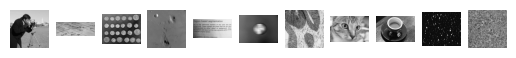

In [5]:
sample_images = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field','grass']
negative_images = []
for name in sample_images:
    img = getattr(skimage.data, name)()
    if len(img.shape) == 3:
            img = skimage.color.rgb2gray(img)
    negative_images.append(img)  
    
fig, ax = plt.subplots(1, len(negative_images))    
for idx,img in enumerate(negative_images):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].axis('off')
plt.show()

From these images we are going to extract some 25x25 patches at different scales:

(495, 25, 25)


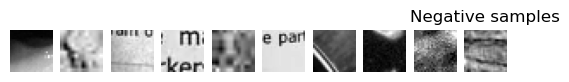

In [6]:
def extract_patches(img, n, patch_size, scale=1.0):
    new_size = (int(scale*patch_size[0]), int(scale*patch_size[1]))
    extractor = sklearn.feature_extraction.image.PatchExtractor(patch_size=new_size, max_patches=n)
    patches = extractor.transform(img[np.newaxis])
    
    if scale != 1:
        patches = np.array([skimage.transform.resize(patch, patch_size) for patch in patches])

    return patches

negative_patches = np.vstack([extract_patches(im, 15, SIZE, scale) 
                                for im in negative_images for scale in [0.5, 1.0, 1.5]])
print(negative_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title('Negative samples')
for i in range(10):
    ax[i].imshow(negative_patches[np.random.randint(0,negative_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

Note that this is a toy face dectector. A real one would need a larger and more complex set of non-face samples.

## Step 2: Extract Haar-like features
There is some functions in the `scikit-image` library to compute haar features from an input image. 

Number of features in an (25, 25) image = 101400


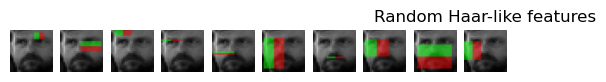

In [7]:
# Extract the haar features for the current image.
# The features specified by 'feature_type'  are computed
# from the integral image only at the positions specified by 'feature_coord'
# If both parameters are none, all the haar features at all the image positions are
# computed
def extract_feature_image(img, feature_type,feature_coord=None):
    
    ii = skimage.transform.integral_image(img)
    features = skimage.feature.haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)
    return features

# Parameter
# Types of features to compute (for simplicity, only two)
FEATURE_TYPES = ['type-2-x', 'type-2-y']

# Returns all the coordinates and feature types that can be computed in an image
# of a given size
feature_coord, feature_type =\
    skimage.feature.haar_like_feature_coord(width=SIZE[1], height=SIZE[0],
                            feature_type=FEATURE_TYPES)

print(f"Number of features in an {SIZE} image = {feature_coord.shape[0]}")
fig, ax = plt.subplots(1,10)
plt.title("Random Haar-like features")

for idx in range(10):
    image = positive_patches[0]
    image = skimage.feature.draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[np.random.randint(0, feature_coord.shape[0])]])
    ax[idx].imshow(image)
    ax[idx].axis('off')
plt.show()

Now, you can compute the Haar-like features from the dataset (it can take a while):

In [8]:
dataset = np.vstack([positive_patches, negative_patches])

t_start = time()
features = np.vstack([extract_feature_image(img, FEATURE_TYPES) for img in dataset])
time_full_feature_comp = time() - t_start

print(f"Computed {features.shape} features in {time_full_feature_comp}s")
        


Computed (895, 101400) features in 146.12551641464233s


Once the features are computed, we can train a classifier in order to distinguish between face and non-face patches. 

To this end, the original approach uses a Cascade Classifier. However, the `scikit-learn` library does not implement this classifier. Even though OpenCV has an implementation of this classifier, it can be only used for inference in python. The training is done by a standalone application that is generated in the compilation of the source code of the library. This way, in this toy example we are going to use a standard classifier to check how the performance of the Haar-like features in the face detection problem.

In [9]:
labels = np.zeros((features.shape[0]))
labels[:positive_patches.shape[0]] = 1 

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)
clf = RandomForestClassifier()

t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")
       

Training finished in 3.512803316116333 s


We can also check the performance of the classifier in the test set:

In [10]:
predictions = clf.predict(X_test)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")


Test success: 0.991304347826087


The Random Forest classifier set the importance of each feature in the final decision so we can visualize which are the most important features to distinguish faces:

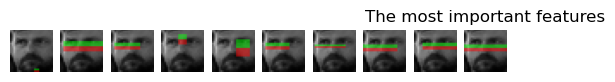

In [11]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

### Exercise
Use some [feature selection technique](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) from the `scikit-learn` library to get the most important features. Train another classifier with these selected  features. Compare this classifier with the previous one in terms of success rate.

*Note*: All the feature selectors from the `scikit-learn` library implement the method `get_support()` that returns a boolean mask where the positions of the selected features are marked as True. You can use this mask to select the Haar-like features to compute in order to speed up the procedure. For example:

In [12]:
# In this example, the mask is manually initialized. In the practice, the
# feature selector computes this mask
mask = np.full(feature_coord.shape, False) 
mask[np.random.randint(0, feature_coord.shape[0], 5)] = True
print(f"Selected features from the first sample: {features[0,mask]}")


# feature_coord and feature_type stores the coordinates and types of all the features
# that can be computed in an input patch. They were computed using the function
# haar_like_feature_coord
print(f"Number of possible features: {feature_coord.shape[0]}")

# Compute only the selected features from the first positive image
sample_features = extract_feature_image(positive_patches[0,:,:], feature_type[mask], feature_coord[mask])
print(f"Features computed using the mask: {sample_features}")


Selected features from the first sample: [  0.58161679  -7.00747812 -39.64641101  -0.23220924  -0.24468817]
Number of possible features: 101400
Features computed using the mask: [  0.58161679  -7.00747812 -39.64641101  -0.23220924  -0.24468817]


In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

dataset = np.vstack([positive_patches, negative_patches])

selector = SelectKBest(f_classif, k=15)
t_start = time()
features = np.vstack([extract_feature_image(img, FEATURE_TYPES) for img in dataset])
selected_features = selector.fit_transform(features, labels)
time_full_feature_comp = time() - t_start

print(f"Computed {selected_features.shape} features in {time_full_feature_comp}s")


Computed (895, 15) features in 143.6006886959076s


In [14]:
X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, train_size=320, stratify=labels, random_state=0)
clf_fs= RandomForestClassifier()

t_start = time()
clf_fs.fit(X_train, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

Training finished in 0.16843748092651367 s


In [15]:
predictions = clf_fs.predict(X_test)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")

Test success: 0.88


The previous one was a bit slower but it was more successfull. For this second method, the bigger the k the higher the success, this is because k is the number of top features to select.

### Exercise

Develop a function that receives an image and detects the faces in it using a sliding window approach. Compare the results using all the features as well as the selected features in terms of computational efficiency and success rate.

**Notes**:
- Take into account that the original size of face images in the training dataset was 62x47 and they were resized to 25x25.
- In order to avoid false positives, if you use a Random Forest classifier, use the function `predict_proba` instead of `predict` to get the probabilities of each class. Use a threshold higher than 0.5 to conclude that a window contains a face.



Detect faces using feature selection: 0.0 s


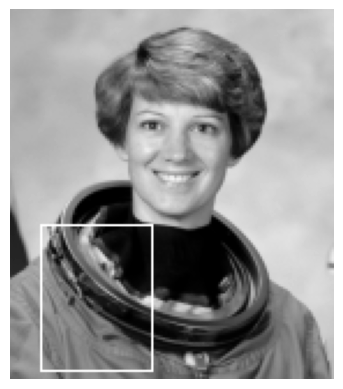

Detect faces using all features: 0.0 s


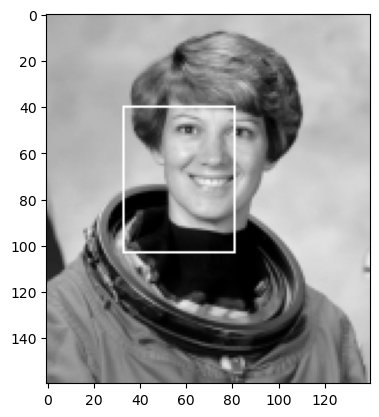

In [19]:
def detect_faces(image, clf, mask=None, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES):
    # Write your code here
    coords = [(np.random.randint(0,image.shape[0]-orig_size[0]),np.random.randint(0,image.shape[1]-orig_size[1]))]
    return coords
    
    
# Test image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.plot()

t_start = time()
coords = detect_faces(test_image, clf_fs, mask)
print(f"Detect faces using feature selection: {time()-t_start} s")

test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()
    
t_start = time()
coords = detect_faces(test_image, clf)
print(f"Detect faces using all features: {time()-t_start} s")

test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()
    